In [1]:
import torch
import torch.nn as nn
import numpy as np
import random

torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)
random.seed(123)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

In [2]:
torch.autograd.set_detect_anomaly(True)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
!CUDA_LAUNCH_BLOCKING=1

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models

In [6]:
# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
from three_d_shapes_ds import ThreeDShapes
trainloader = torch.utils.data.DataLoader(
                                      ThreeDShapes(transform=torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), torchvision.transforms.Resize((32, 32)),
                                        torchvision.transforms.ToTensor(),
                                      ]), filtered = True),
                                      batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(
                                      ThreeDShapes(transform=torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), torchvision.transforms.Resize((32, 32)),
                                        torchvision.transforms.ToTensor(),
                                      ]), filtered = True),
                                      batch_size=32, shuffle=True)
#Image shape: 3x32x32

In [8]:
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
# change the number of classes 
vgg16.classifier[6].out_features = 16
# freeze convolution weights
for param in vgg16.features.parameters():
    param.requires_grad = True

In [10]:
from models import DisentangledLinear, BlockDropout

n_classes = 16

ncc = 3 #number of connected components

#vgg16.classifier[3] = DisentangledLinear(vgg16.classifier[3].in_features, vgg16.classifier[3].out_features).to(device)
#vgg16.classifier[6] = DisentangledLinear(vgg16.classifier[6].in_features, n_classes).to(device)

vgg16.classifier[3] = DisentangledLinear(vgg16.classifier[3].in_features, 200).to(device)
vgg16.classifier[6] = DisentangledLinear(200, n_classes).to(device)
vgg16.classifier[5] = BlockDropout(vgg16.classifier[6], ncc=ncc, p=0.8, apply_to="in")

# disentangle layers right after convolutions
# vgg16.classifier[0] = DisentangledLinear(vgg16.classifier[0].in_features, vgg16.classifier[0].out_features).to(device)
# vgg16.classifier[3] = DisentangledLinear(vgg16.classifier[3].in_features, vgg16.classifier[3].out_features).to(device)

# vgg16.classifier[2] = BlockDropout(vgg16.classifier[3], ncc=ncc, p=0.1, apply_to="in")

for param in vgg16.features.parameters():
    param.requires_grad = True

In [11]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
# optimizer
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)
# loss function
criterion = nn.CrossEntropyLoss()

In [13]:
def target_vec_to_class(vec):
    labels = (vec[:, 0] == 0).int()*(2**3) + (vec[:, 1] == 0).int()*(2**2) + (vec[:, 2] == 0)*2 + (vec[:, 4] == 0)
    return labels.long()

In [14]:
# validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0], data[1]
        target = target_vec_to_class(target)
                
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
    
    return val_loss, val_accuracy

In [15]:
def neuron_wise_br(model, layer, blocks, examples, ncc):
    model.eval()
    br_wo_neuron = [np.inf]*layer.out_features
    for n in range(layer.out_features):
        if layer.out_mask is not None:
            mask = torch.clone(layer.out_mask)
        else:
            mask = torch.ones(layer.out_features, dtype=torch.bool)
        if mask[n] > 0:
            mask[n] = 0
            a_n = normalize_w(layer.weight[mask])
            _, s, _ = torch.svd(a_n)
            br_wo_neuron[n] = ncc - torch.sum(s[:ncc]).detach().cpu()
    return br_wo_neuron

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_blocked_weights(layer):
    plt.figure(figsize=(20, 7))
    blocks_in = compute_layer_blocks_in(layer, ncc)
    blocks_out = compute_layer_blocks_out(layer, ncc)
    plt.imshow(layer.weight[np.argsort(blocks_out)][:, np.argsort(blocks_in)].cpu().detach().numpy())
    plt.show()

In [17]:
from models import block_regularizer, compute_layer_blocks_in, compute_layer_blocks_out
from spectral_utils import normalize_w
import numpy as np

def prune(model, layer_out, layer_in, ncc):
    blocks = compute_layer_blocks_in(layer_out, ncc)
    for batch_features in testloader:
        batch_features = batch_features[0]
        test_examples = batch_features.to(device)
        break
    re = neuron_wise_br(model, layer_in, blocks, test_examples, ncc)
    removal_mask = layer_in.out_mask
    if removal_mask is None:
        removal_mask = torch.ones(layer_in.out_features, dtype=torch.bool)
    removal_mask[np.argmin(re)] = 0
    layer_out.turn_input_neurons_off(removal_mask)
    layer_in.turn_output_neurons_off(removal_mask)
    #layer_out.remove_neurons_in(removal_mask)
    #layer_in.remove_neurons_out(removal_mask)
    #optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)
    print("n neurons:"+str(layer_out.in_mask.sum().item()))
    #print("n neurons:"+str(layer_out.in_features))

In [18]:
# training function
n_epochs = 30
total_batches = len(trainloader)*n_epochs
layer_size_reduction = 100
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0], data[1]
        target = target_vec_to_class(target)
        
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        block_reg = block_regularizer(model.classifier[6], ncc)
        loss = criterion(output, target)# + block_reg
        #loss = block_reg
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        if (i)%(int(round(total_batches/(layer_size_reduction)))) == 0:
            print("Block regularizer "+str(block_reg.item()))
            #plot_blocked_weights(vgg16.classifier[6])
            #plot_blocked_weights(vgg16.classifier[3])
            prune(model, vgg16.classifier[6], vgg16.classifier[3], ncc)
            
            
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy, block_reg.item()

In [19]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy, br = [], [], []
start = time.time()
for epoch in range(n_epochs):
    print(epoch)
    train_epoch_loss, train_epoch_accuracy, block_reg = fit(vgg16, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(vgg16, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    br.append(block_reg)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    torch.save(vgg16, 'models/vgg16disen_3dshapes_3bl.pt')
end = time.time()
print((end-start)/60, 'minutes')

0
Block regularizer 1.6519362926483154


/diseNN/models.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.in_mask = torch.tensor(mask, requires_grad=False).to(device)
/diseNN/models.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.out_mask = torch.tensor(mask, requires_grad=False).to(device)


n neurons:199
Block regularizer 1.6488776206970215
n neurons:198
Block regularizer 1.6489901542663574
n neurons:197
Block regularizer 1.6488767862319946
n neurons:196
Train Loss: 0.0546, Train Acc: 56.77
Val Loss: 0.0179, Val Acc: 77.19
1
Block regularizer 1.6503651142120361
n neurons:195
Block regularizer 1.6503247022628784
n neurons:194
Block regularizer 1.6506304740905762
n neurons:193
Block regularizer 1.6505156755447388
n neurons:192
Train Loss: 0.0140, Train Acc: 82.60
Val Loss: 0.0088, Val Acc: 87.71
2
Block regularizer 1.6500521898269653
n neurons:191
Block regularizer 1.6509226560592651
n neurons:190
Block regularizer 1.6516129970550537
n neurons:189
Block regularizer 1.6508567333221436
n neurons:188
Train Loss: 0.0077, Train Acc: 90.26
Val Loss: 0.0053, Val Acc: 94.27
3
Block regularizer 1.6505013704299927
n neurons:187
Block regularizer 1.6495174169540405
n neurons:186
Block regularizer 1.649611234664917
n neurons:185
Block regularizer 1.6491074562072754
n neurons:184
Train 

11.784886149565379 minutes


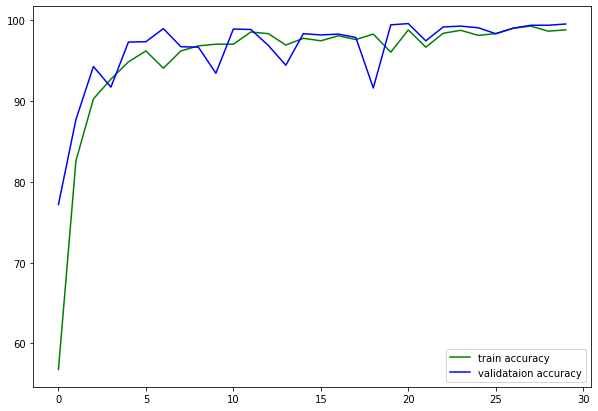

In [20]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

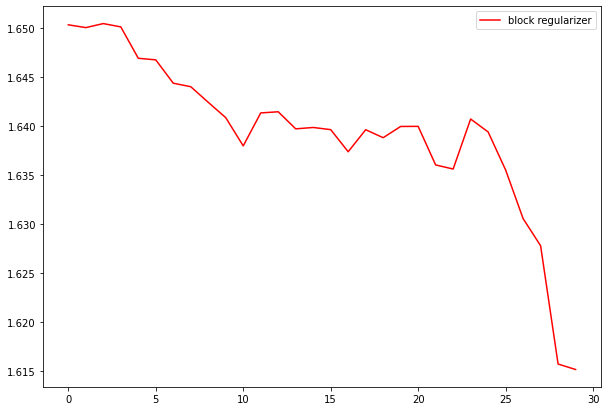

In [21]:
plt.figure(figsize=(10, 7))
plt.plot(br, color='red', label='block regularizer')
plt.legend()
plt.savefig('br.png')
plt.show()

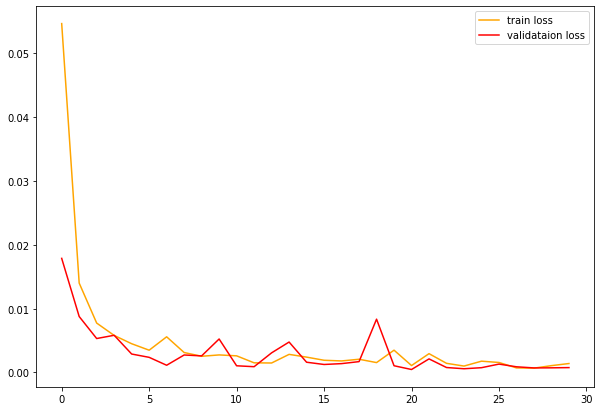

In [22]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [27]:
#find activations for images


class SaveOutput:
    def __init__(self):
        self.outputs = None
        
    def __call__(self, module, module_in, module_out):
        self.outputs = module_out.detach().cpu().numpy()

hook = SaveOutput()
vgg16.classifier[3].register_forward_hook(hook)

weighted_images_pos = np.zeros((200, 3, 32, 32))
weighted_images_neg = np.zeros((200, 3, 32, 32))
act_max = np.zeros(200)

for i, data in enumerate(testloader):
    data, target = data[0], data[1]
    data = data.to(device)
    output = vgg16(data)
    data = data.detach().cpu().numpy()

    batch_ext = np.repeat(data[:, np.newaxis, :, :], 200, axis=1)
    weighted_images_pos += np.average(batch_ext * np.expand_dims((hook.outputs > 0.5) * hook.outputs, axis=(2, 3, 4)), axis=0)
    weighted_images_neg += np.average(batch_ext * np.expand_dims((hook.outputs < 0) * -hook.outputs, axis=(2, 3, 4)), axis=0)


    act_max = np.max(np.stack([act_max, np.max(hook.outputs, axis=0)], axis=0), axis=0)

weighted_images_pos /= np.expand_dims(np.max(weighted_images_pos, axis=(1, 2, 3)), axis=(1, 2, 3))
weighted_images_neg /= np.expand_dims(np.max(weighted_images_neg, axis=(1, 2, 3)), axis=(1, 2, 3))

/tmp/ipykernel_24754/88654409.py:31: RuntimeWarning: invalid value encountered in true_divide
  weighted_images_pos /= np.expand_dims(np.max(weighted_images_pos, axis=(1, 2, 3)), axis=(1, 2, 3))
/tmp/ipykernel_24754/88654409.py:32: RuntimeWarning: invalid value encountered in true_divide
  weighted_images_neg /= np.expand_dims(np.max(weighted_images_neg, axis=(1, 2, 3)), axis=(1, 2, 3))


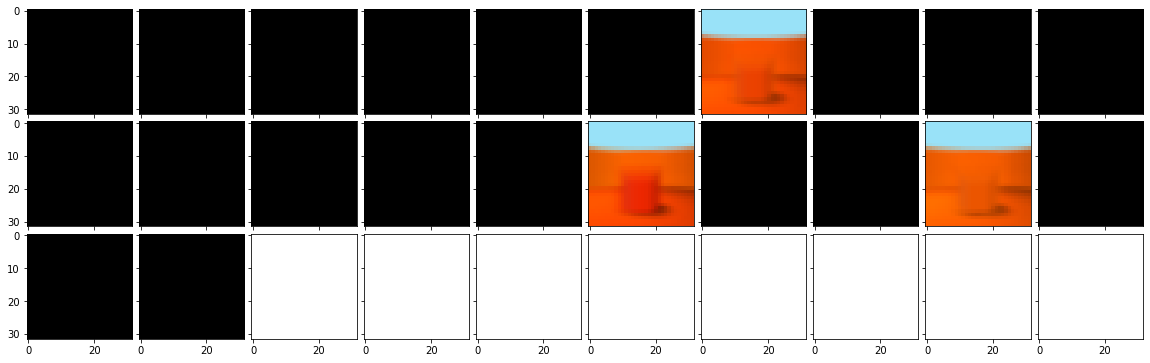

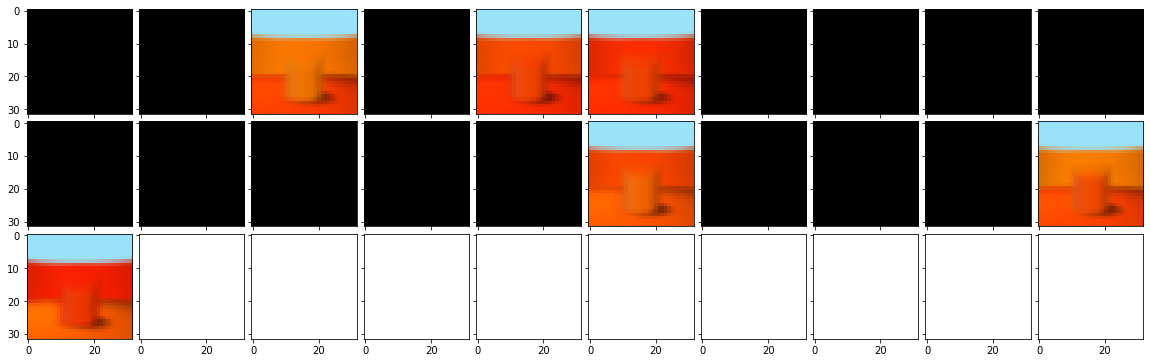

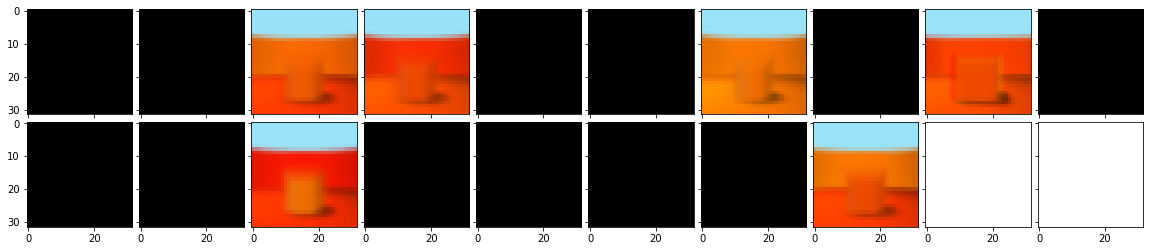

In [28]:
from mpl_toolkits.axes_grid1 import ImageGrid

blocks = compute_layer_blocks_in(vgg16.classifier[6], ncc)
for c in range(ncc):
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(int(np.ceil((blocks==c).sum()/10)), 10),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )
    #for ax, im in zip(grid, weighted_images_pos*np.expand_dims(blocks==c, axis=(1, 2, 3))):
    for ax, im in zip(grid, weighted_images_pos[blocks==c]):
        ax.imshow(im.transpose(1, 2, 0))

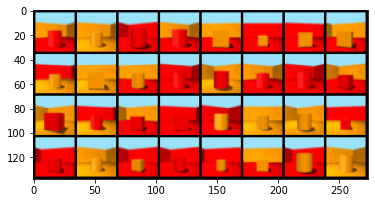

Image shape: torch.Size([3, 32, 32])
tensor([10,  0, 14, 10,  9, 13, 13,  9,  4,  1,  8, 14,  2, 10, 14, 11,  3,  6,
        11, 15, 12,  0,  0,  7, 15,  0, 13, 14, 12,  9, 12,  0])


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from col_mnist import ColMNIST

plt.rcParams["axes.grid"] = False
device = "cuda" if torch.cuda.is_available() else "cpu"

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
data, target = dataiter.next()
target = target_vec_to_class(target)
imshow(torchvision.utils.make_grid(data))
img_shape = data[0].shape
print("Image shape: {}".format(img_shape))
print(target)

In [26]:
from explainn_code.grab_functions import db_from_dat_with_labels, write_pic_as_sets

tail = []
head = []

for i, data in enumerate(testloader):
    data, target = data[0], data[1]
    target = target_vec_to_class(target)
    data = data.to(device)
    target = target.to(device)
    output = vgg16(data).cpu()

    head.append(vgg16.classifier[6].detach().cpu().numpy())
    tail.append(target.detach().cpu().numpy())
head = np.concatenate(head)
tail = np.concatenate(tail)

ModuleNotFoundError: No module named 'explainn_code'

In [ ]:
write_pic_as_sets(head, "vgg_head_blocked_v1.data")

In [ ]:
write_pic_as_sets(tail "tail_v1.dat")

In [ ]:
!conda info --envs